In [385]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [386]:
# Data Preparation

# Parameters
tickers = ['AAPL', 'COKE', 'VZ', 'F']
tickers.sort()

start = '2016-01-01'

# YF download
df = yf.download(tickers, start=start)

# Reformat Dataframe
df = df.stack().reset_index()

# Add daily return column
df['Return'] = df.groupby("Ticker")['Adj Close'].pct_change()

df = df.dropna()

df

[*********************100%%**********************]  4 of 4 completed
C:\Users\andre\AppData\Local\Temp\ipykernel_17664\1719358244.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return
4,2016-01-05,AAPL,23.288244,25.677500,26.462500,25.602501,26.437500,223164000,-0.025059
5,2016-01-05,COKE,166.498138,176.740005,179.410004,174.300003,177.020004,32600,0.009654
6,2016-01-05,F,8.630338,13.720000,14.000000,13.510000,13.970000,50267500,-0.017896
7,2016-01-05,VZ,29.956106,46.500000,46.549999,45.630001,46.200001,15632800,0.013734
8,2016-01-06,AAPL,22.832502,25.174999,25.592501,24.967501,25.139999,273829600,-0.019570
...,...,...,...,...,...,...,...,...,...
8687,2024-08-20,VZ,40.849998,40.849998,40.959999,40.630001,40.660000,8784000,0.002700
8688,2024-08-21,AAPL,226.399994,226.399994,227.979996,225.050003,226.520004,34729100,-0.000486
8689,2024-08-21,COKE,1321.290039,1321.290039,1322.589966,1284.989990,1292.040039,70200,0.042052
8690,2024-08-21,F,10.850000,10.850000,10.970000,10.750000,10.840000,48881900,0.015918


In [387]:
benchmark = 'IWV'

# YF download
bmk = yf.download(benchmark, start=start)

# Reformat Dataframe
bmk = bmk.reset_index()

# Add daily return column
bmk['Return'] = bmk['Adj Close'].pct_change()

bmk = bmk.dropna()

bmk = bmk[['Date', 'Return']]

bmk

[*********************100%%**********************]  1 of 1 completed


,Date,Return
1,2016-01-05,0.002450
2,2016-01-06,-0.013483
3,2016-01-07,-0.023918
4,2016-01-08,-0.011464
5,2016-01-11,-0.000797
...,...,...
2168,2024-08-15,0.017168
2169,2024-08-16,0.001939
2170,2024-08-19,0.010247
2171,2024-08-20,-0.002512


In [388]:
# Create assets dataframe

assets = df.groupby('Ticker')['Return'].mean().rename("Expected Return").to_frame().reset_index()

# assets['Volatility'] = df.groupby('Ticker')['Return'].std().to_list()

assets

,Ticker,Expected Return
0,AAPL,0.001203
1,COKE,0.001246
2,F,0.000374
3,VZ,0.000228


In [389]:
# Returns dataframe
return_matrix = df[['Date','Ticker','Return']].pivot(index='Date', columns='Ticker', values='Return').dropna()

return_matrix

Ticker,AAPL,COKE,F,VZ
Date,,,,
2016-01-05,-0.025059,0.009654,-0.017896,0.013734
2016-01-06,-0.019570,0.018162,-0.044461,-0.009034
2016-01-07,-0.042205,-0.014004,-0.031274,-0.005492
2016-01-08,0.005288,0.002649,-0.012598,-0.009720
2016-01-11,0.016192,-0.029961,0.018341,0.005800
...,...,...,...,...
2024-08-15,0.013531,0.009538,0.027505,-0.021027
2024-08-16,0.005918,-0.007220,0.004780,0.014236
2024-08-19,-0.000708,0.010404,0.019981,0.003201


In [390]:
# Covariance Matrix
cov_matrix = return_matrix.cov().values

cov_matrix

array([[3.33605425e-04, 1.08169348e-04, 1.46861249e-04, 5.03437423e-05],
       [1.08169348e-04, 5.70170689e-04, 1.38455291e-04, 6.36599622e-05],
       [1.46861249e-04, 1.38455291e-04, 5.54554119e-04, 6.79249419e-05],
       [5.03437423e-05, 6.36599622e-05, 6.79249419e-05, 1.53620364e-04]])

In [391]:
# Expected Returns Vector
expected_returns = assets['Expected Return'].values

expected_returns

array([0.00120273, 0.0012461 , 0.00037427, 0.00022805])

In [392]:
# Benchmark Expected Return
bmk_return = bmk['Return'].mean()

bmk_return

np.float64(0.0005870228152052177)

In [393]:
# Portfolio metric functions
def portfolio_return(weights, expected_returns):
    return np.sum(weights * expected_returns) - bmk_return

def tracking_error(weights, cov_matrix):
    return np.sqrt(np.dot(np.matmul(weights.T,cov_matrix),weights))

def negative_information_ratio(weights, expected_returns, cov_matrix):
    port_er = portfolio_return(weights, expected_returns)
    active_risk = tracking_error(weights, cov_matrix)
    return -port_er / active_risk

In [394]:
# Display Weights Function
def display_weights(tickers, weights):
    df = pd.DataFrame()
    df['Ticker'] = tickers
    df['Weight'] = [round(weight, 2) for weight in weights]

    display(df)

In [395]:
# Baseline results

# Initial Weights
size = len(tickers)
initial_weights = np.array([1/size] * size)

# Baseline Results
port_return = portfolio_return(initial_weights, expected_returns)
port_tracking_error = tracking_error(initial_weights,cov_matrix)
port_ir = port_return / port_tracking_error

#Display
display_weights(tickers, initial_weights)
print(f"Portfolio Return: {round(port_return,2)} %")
print(f"Portfolio Tracking Error: {round(port_tracking_error,2)} %")
print(f"Portfolio Information Ratio: {round(port_ir,2)}")

,Ticker,Weight
0,AAPL,0.25
1,COKE,0.25
2,F,0.25
3,VZ,0.25


Portfolio Return: 0.0 %
Portfolio Tracking Error: 0.01 %
Portfolio Information Ratio: 0.01


In [396]:
# Optimization

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1
bounds = tuple((-1, 1) for _ in range(len(tickers)))  # each weight between -1 and 1

# Result
result = minimize(negative_information_ratio, initial_weights, 
                  args=(expected_returns, cov_matrix),
                  method='SLSQP',bounds=bounds, constraints=constraints) #

optimal_weights = result.x

optimal_weights

array([ 1.        ,  0.9898542 , -0.29116944, -0.69868476])

In [397]:
# Optimal Results
opt_port_return = portfolio_return(optimal_weights, expected_returns)
opt_port_tracking_error = tracking_error(optimal_weights,cov_matrix)
opt_port_ir = opt_port_return / opt_port_tracking_error

# Display
display_weights(tickers,optimal_weights)
print(f"Optimized Portfolio Return: {round(opt_port_return,2)} %")
print(f"Optimized Portfolio Tracking Error: {round(opt_port_tracking_error,2)} %")
print(f"Optimized Portfolio Information Ratio: {round(opt_port_ir,2)}")

,Ticker,Weight
0,AAPL,1.00
1,COKE,0.99
2,F,-0.29
3,VZ,-0.70


Optimized Portfolio Return: 0.0 %
Optimized Portfolio Tracking Error: 0.03 %
Optimized Portfolio Information Ratio: 0.05


In [398]:
# Efficient Frontier Chart

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((-1, 1) for _ in range(len(tickers)))  # each weight between -1 and 1

# Mean Variance Efficient function
def mve_portfolio(target_return, expected_returns, cov_matrix):
    n = len(tickers)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(tracking_error, n*[1./n,], args=args[1],
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [400]:
n_points = 100
target_returns = np.linspace(0,2*opt_port_return, n_points)
mve_portfolios = [mve_portfolio(target, expected_returns, cov_matrix) for target in target_returns]

returns = [portfolio_return(w, expected_returns) for w in mve_portfolios]
tracking_errors = [tracking_error(w, cov_matrix) for w in mve_portfolios]

portfolios = pd.DataFrame()
portfolios['Name'] = [f"Portfolio {x+1}" for x in range(len(mve_portfolios))]

for index in range(len(tickers)):
    portfolios[tickers[index]] = np.array([row[index] for row in mve_portfolios])
    portfolios[tickers[index]] = round(portfolios[tickers[index]],2)
    
portfolios['Expected Excess Return'] = returns
portfolios['Tracking Error'] = tracking_errors
portfolios['Information Ratio'] = portfolios['Expected Excess Return'] / portfolios['Tracking Error']

portfolios

,Name,AAPL,COKE,F,VZ,Expected Excess Return,Tracking Error,Information Ratio
0,Portfolio 1,0.24,0.11,0.04,0.60,7.142626e-14,0.010988,6.500522e-12
1,Portfolio 2,0.27,0.12,0.04,0.57,3.193654e-05,0.011051,2.889793e-03
2,Portfolio 3,0.29,0.13,0.03,0.55,6.387308e-05,0.011140,5.733499e-03
3,Portfolio 4,0.31,0.15,0.02,0.52,9.580962e-05,0.011254,8.513619e-03
4,Portfolio 5,0.33,0.16,0.01,0.50,1.277462e-04,0.011391,1.121482e-02
...,...,...,...,...,...,...,...,...
95,Portfolio 96,1.00,1.00,0.00,-1.00,1.633764e-03,0.032338,5.052194e-02
96,Portfolio 97,1.00,1.00,0.00,-1.00,1.633764e-03,0.032338,5.052194e-02
97,Portfolio 98,1.00,1.00,0.00,-1.00,1.633764e-03,0.032338,5.052194e-02
98,Portfolio 99,1.00,1.00,-0.00,-1.00,1.633764e-03,0.032338,5.052194e-02


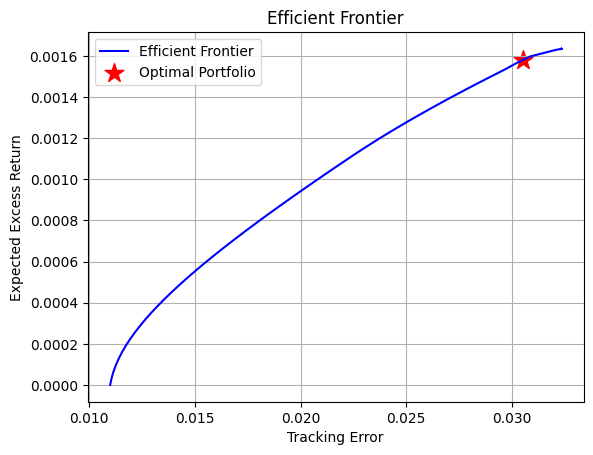

In [ ]:
plt.plot(tracking_errors, returns, 'b-', label='Efficient Frontier')
plt.scatter(opt_port_tracking_error, opt_port_return, color='r', marker='*', s=200, label='Optimal Portfolio')

plt.xlabel('Tracking Error')
plt.ylabel('Expected Excess Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

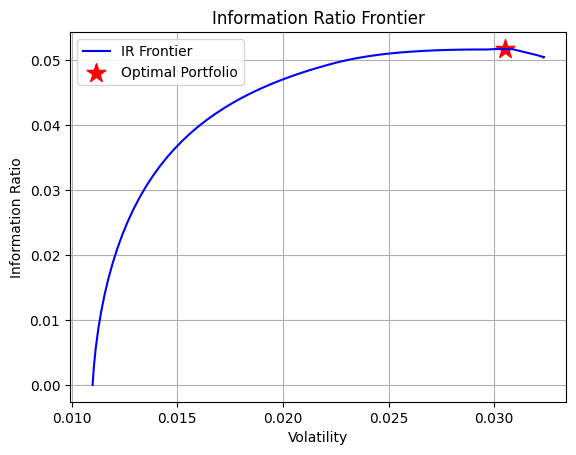

In [ ]:
# Information Ratio Graph
plt.plot(portfolios['Tracking Error'], portfolios['Information Ratio'], 'b-', label='IR Frontier')
plt.scatter(opt_port_tracking_error, opt_port_ir, color='r', marker='*', s=200, label='Optimal Portfolio')
    
plt.xlabel('Volatility')
plt.ylabel('Information Ratio')
plt.title('Information Ratio Frontier')
plt.legend()
plt.grid(True)
plt.show()